In [45]:
import numpy as np
import pandas as pd 
from frites import set_mpl_style
import scipy.stats as stats
import matplotlib.pyplot as plt


In [46]:
set_mpl_style()
data=pd.read_hdf("./data/s1_CP_smoothPursuitData.h5")

In [47]:
data

,cond,trial,target_dir,velocity_model_x,velocity_model_y,end_anti_x,end_anti_y,velocity_trad_x,velocity_trad_y,start_anti_x,start_anti_y,ramp_pursuit_x,ramp_pursuit_y,steady_state_x,steady_state_y,classic_lat_x,classic_lat_y,new_lat_x,new_lat_y,new_cond
0,1,0,DR,0.857120,0.000000,698.999993,70.999994,0.614465,-0.146133,578.998553,69.999994,97.663161,61.856076,10.524606,9.684345,NaN,NaN,802.0,185.0,5
1,1,1,DR,1.648825,0.076251,704.001284,106.000210,1.081719,1.045021,276.453248,-45.794730,49.754732,35.589572,10.988607,10.503517,NaN,NaN,731.0,129.0,5
2,1,2,DL,-0.083921,-0.734047,700.000019,96.393593,1.184549,-0.111484,598.895295,-73.001442,35.140086,36.888147,12.720180,9.311993,NaN,NaN,768.0,117.0,5
3,1,3,DL,-2.069903,-1.026787,724.382811,84.000096,-0.806350,-2.219277,187.628695,-392.670569,10.160336,122.027632,21.373929,7.396573,NaN,NaN,745.0,155.0,5
4,1,4,UL,-0.917457,-1.935414,714.999994,88.001148,-0.827212,-2.295942,213.651397,-133.914420,40.744401,10.427677,10.704986,14.134614,NaN,NaN,766.0,117.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,9,395,DR,1.645191,0.000000,700.999997,113.540056,1.164362,0.626013,469.903789,112.540056,59.086193,45.438016,12.049005,11.830297,NaN,NaN,724.0,129.0,2
3151,9,396,UR,-0.338071,0.488375,693.000001,94.000002,-0.002038,-0.035164,334.281164,-50.699172,14.469101,76.365055,21.935480,11.062987,NaN,355.0,708.0,135.0,2
3152,9,397,DL,0.888913,1.040543,704.999528,95.889933,0.947015,0.303217,534.988533,-228.183355,66.167845,34.798088,13.067811,10.103381,NaN,NaN,745.0,119.0,2
3153,9,398,DR,-0.910170,0.000000,696.434362,101.993039,-1.815893,-0.797842,244.815311,100.993039,39.416602,30.286021,13.174095,10.487716,NaN,NaN,731.0,114.0,2


In [48]:
class BetaModel():
    def __init__(self,v_target,leak_factor=1):             
                
        self.a = 1  # the number of times this action returned a win       
        self.b = 1  # the number of times this action returned a loss
        self.n=0 # number of trials 
        self.omega=leak_factor
        self.vt=v_target #is the absolute value of the target velocity
        # pass the true probablity of the outcome|action taken              
    
    def outcome(self,q):        
        #return the boolean if 1 means that the eye and target have the same direction otherwwise the eye anticpates in
        #the wrong direction
        return stats.bernoulli.rvs(q) 
                    
    def update(self,reward):
        """ 
        reward here is the direction of the eye: 1 if it is the same as the target's direction otherwise 0
        
        """
        self.n += 1    
        
        if reward==1:
            self.a += 1
        
        else:
            self.b += 1
        
        self.a*=self.omega
        self.b*=self.omega
        
    def reset(self):
        self.n=0
        self.a=1
        self.b=1

    def sample(self):
         #return a value sampled from the beta distribution 
        return np.random.beta(self.a,self.b)
        #return np.mean(np.random.beta(self.a,self.b,10))

    def velocity(self):
        p=self.a/(self.a+self.b)
        return self.vt*1/2*np.log(p/(1-p))
        
   

In [49]:
stats.bernoulli.rvs(0.5)

0

In [50]:
v_target=10
agent=BetaModel(v_target)
mu=[]
V=[]
O=[]
VVV=[]
OOO=[]
MU=[]
#Probability of the target going right 
P=[0.25,.5,0.75]
V_THEOS=[]
for p in P:
    for i in range(200):
        o=agent.outcome(p)
        O.append(o)
        V.append(agent.velocity())
        agent.update(o)
        mu.append(agent.a/(agent.a+agent.b))
    VVV.append(V)
    OOO.append(O)
    MU.append(mu)
    
    print("The estimated probability of the target going right estimated by the agent is:",agent.a/(agent.a+agent.b))
    print("The antipatory velocity of the agent is ", V[-1])
    v_theo=v_target*1/2*np.log(p/(1-p)) 
    V_THEOS.append(v_theo)
    print("The optimal anticpatory theorical velocitiy is " ,v_theo,'\n')
    mu=[]
    V=[]
    O=[]
    agent.reset()
    

The estimated probability of the target going right estimated by the agent is: 0.27722772277227725
The antipatory velocity of the agent is  -4.756910258427125
The optimal anticpatory theorical velocitiy is  -5.493061443340549 

The estimated probability of the target going right estimated by the agent is: 0.48514851485148514
The antipatory velocity of the agent is  -0.24880754779531913
The optimal anticpatory theorical velocitiy is  0.0 

The estimated probability of the target going right estimated by the agent is: 0.7821782178217822
The antipatory velocity of the agent is  6.360280857150235
The optimal anticpatory theorical velocitiy is  5.493061443340549 



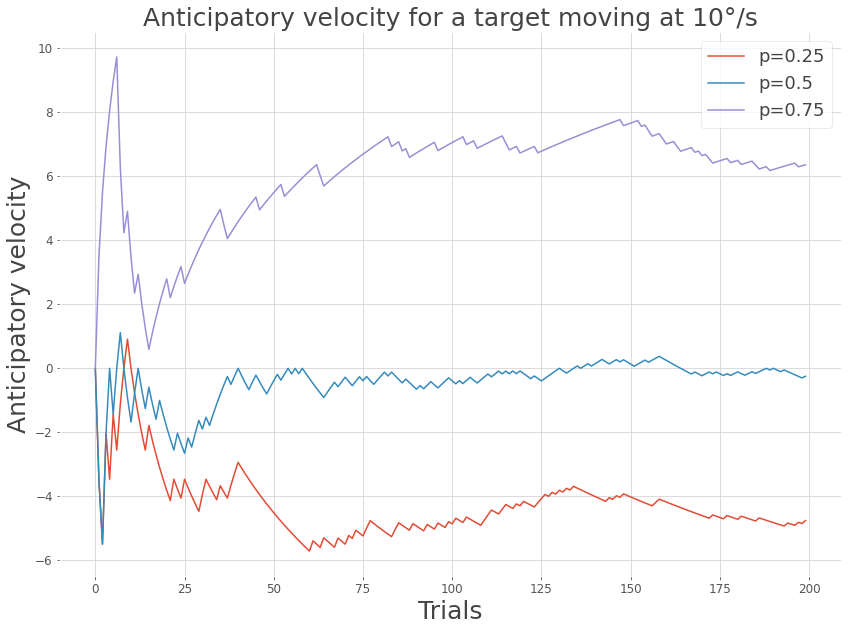

In [51]:
for v,p in zip(VVV,P):
    plt.plot(v,label=f'p={p}')
plt.xlabel("Trials",fontsize=25)
plt.ylabel("Anticipatory velocity",fontsize=25)
plt.title("Anticipatory velocity for a target moving at 10°/s",fontsize=25)
plt.legend()

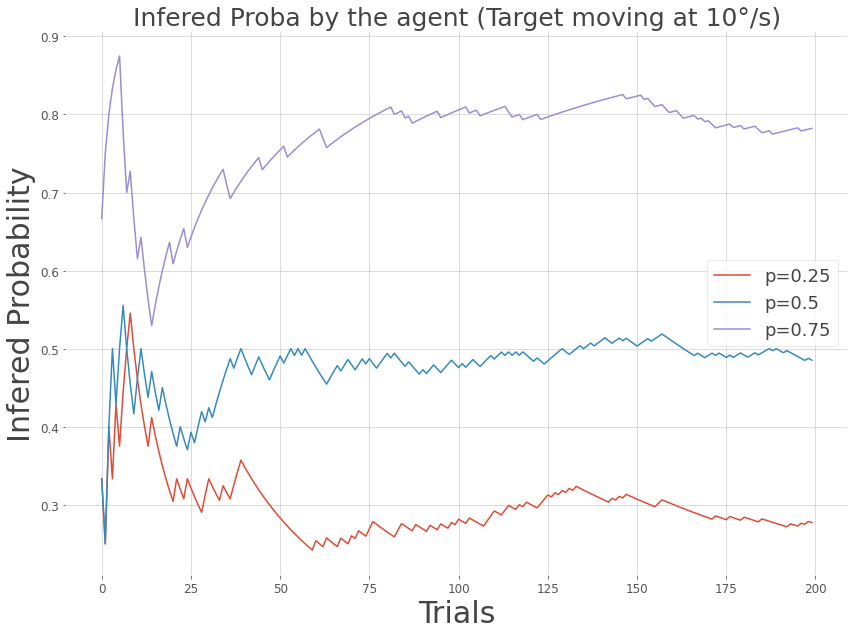

In [52]:
for m,p in zip(MU,P):
    plt.plot(m,label=f'p={p}')
plt.xlabel("Trials",fontsize=30)
plt.ylabel("Infered Probability",fontsize=30)
plt.title("Infered Proba by the agent (Target moving at 10°/s)",fontsize=25)
plt.legend()

In [53]:
ERRS=[]
for O,V in zip(OOO,VVV):
    Err=np.array(O)*np.exp(1-np.array(V)/v_target) + (1-np.array(O))*np.exp(1+np.array(V)/v_target)
    ERRS.append(Err)

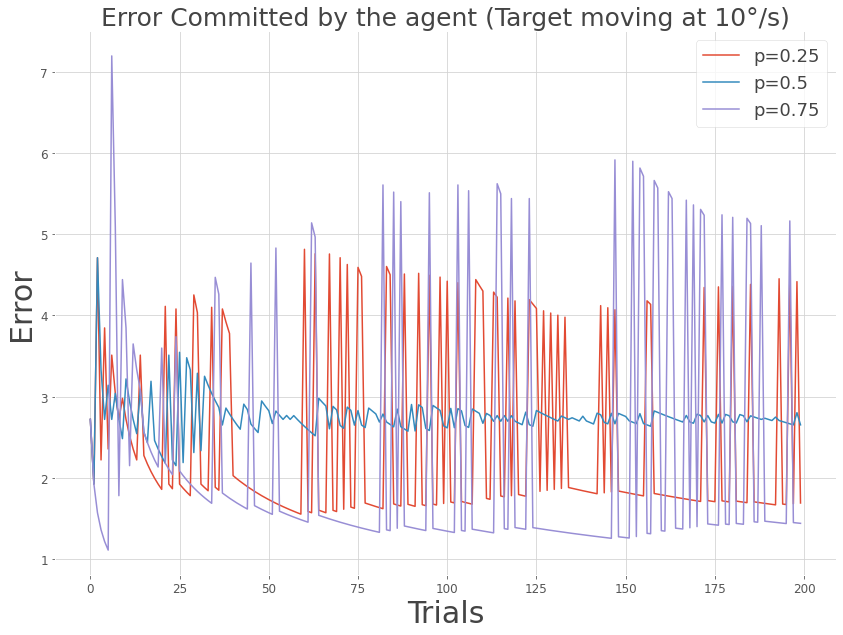

In [54]:
for e,p in zip(ERRS,P):
    plt.plot(e,label=f'p={p}')

plt.xlabel("Trials",fontsize=30)
plt.ylabel("Error",fontsize=30)
plt.title("Error Committed by the agent (Target moving at 10°/s)",fontsize=25)
plt.legend()

In [55]:
for e,v_th,p in zip(ERRS,V_THEOS,P):
    theo_Err=np.exp(1)*(np.exp(v_th/v_target)-2*p*np.sinh(v_th/v_target))
    print("Empirical error of the agent is ", np.mean(e))
    print("Theoritical error of the agent is ",theo_Err,'\n')

Empirical error of the agent is  2.4643616326165314
Theoritical error of the agent is  2.3541011180911466 

Empirical error of the agent is  2.7506589973726965
Theoritical error of the agent is  2.718281828459045 

Empirical error of the agent is  2.274875555950413
Theoritical error of the agent is  2.3541011180911466 



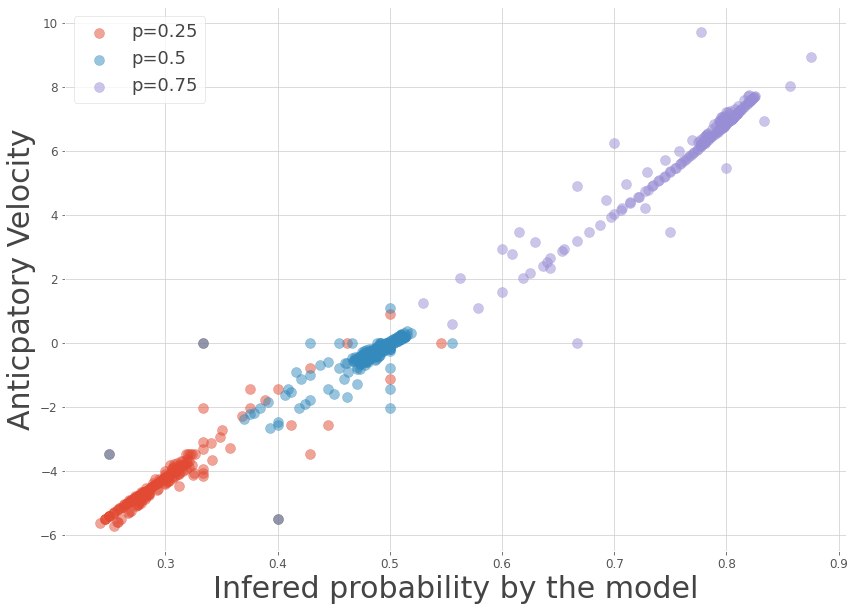

In [56]:
for m,v,p in zip(MU,VVV,P):
    plt.scatter(m,v,s=100,label=f'p={p}',alpha=0.5)
plt.xlabel("Infered probability by the model",fontsize=30)
plt.ylabel("Anticpatory Velocity",fontsize=30)
plt.legend()

Text(0.5, 1.0, 'Theorical Plot of the Relationship: Proba & Velocity')

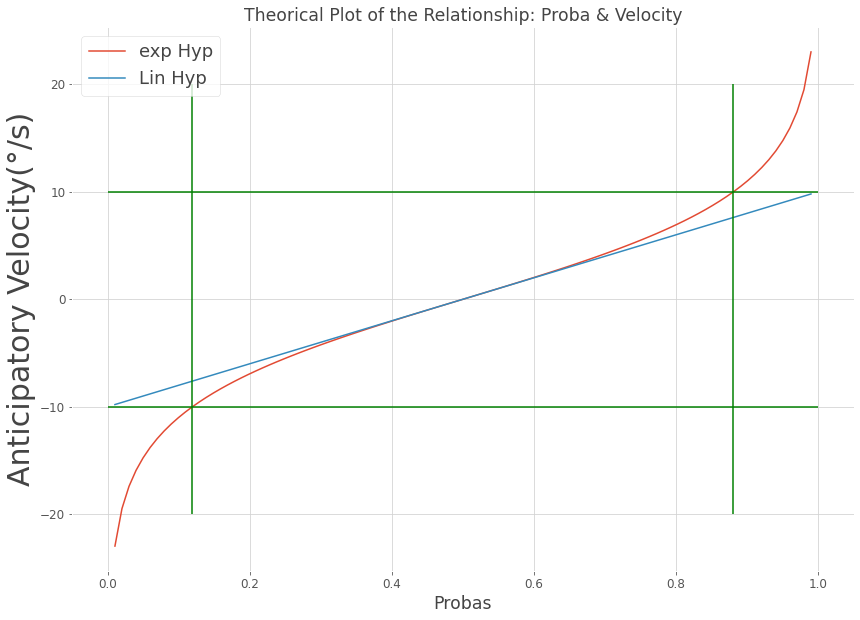

In [61]:
#Theorical plot
P=np.linspace(0.01,1,100,endpoint=False)
VV=v_target*1/2*np.log(P/(1-P))
plt.plot(P,VV,label="exp Hyp")
VV=v_target*(2*P-1)
plt.plot(P,VV,label="Lin Hyp")
plt.hlines(-v_target,0,1,colors="green")
plt.hlines(v_target,0,1,colors="green")
plt.vlines(1/(np.exp(2)+1),-20,20,colors="green")
plt.vlines(1/(np.exp(-2)+1),-20,20,colors="green")
plt.xlabel("Probas")
plt.ylabel("Anticipatory Velocity(°/s)",fontsize=30)
plt.legend()
plt.title("Theorical Plot of the Relationship: Proba & Velocity")


In [42]:
1/(np.exp(2)+1)

0.11920292202211755

In [43]:
1/(np.exp(-2)+1)

0.8807970779778823

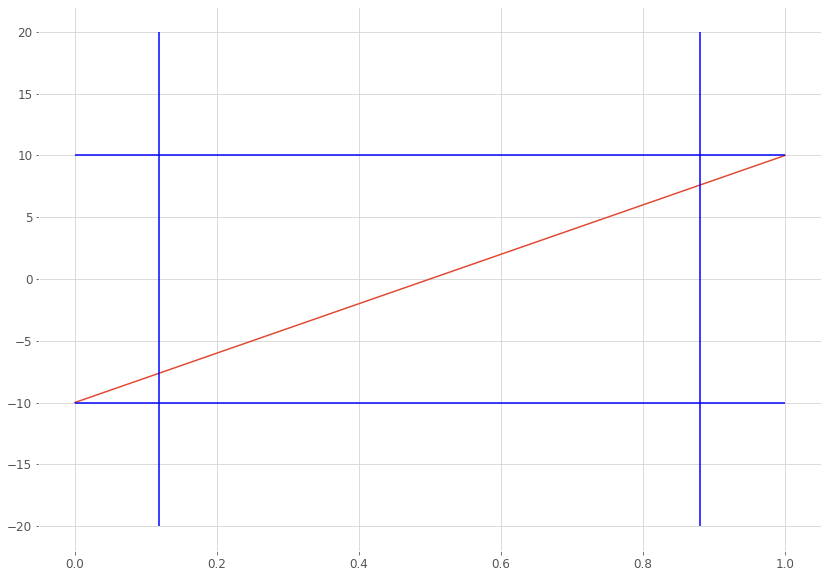

In [57]:
#Theoritical plot
P=np.linspace(0.0,1,100)
VV=v_target*(2*P-1)
plt.plot(P,VV)
plt.hlines(-v_target,0,1,colors="blue")
plt.hlines(v_target,0,1,colors="blue")
plt.vlines(1/(np.exp(2)+1),-20,20,colors="blue")
plt.vlines(1/(np.exp(-2)+1),-20,20,colors="blue")